In [370]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import f90_src
import scipy
import math
from scipy.optimize import minimize


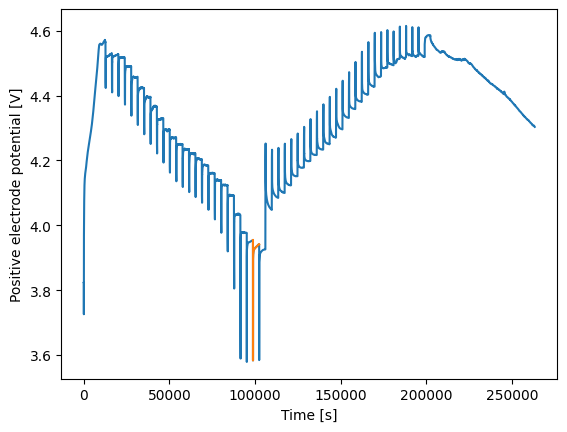

In [371]:
#Read in the experiental data 
df = pd.read_csv("data3.csv")
t = df['Time [s]']
t = t.to_numpy(t)
pot = df['Positive electrode potential [V]']
pot = pot.to_numpy(pot)
curr = df['Current [A]']
curr = curr.to_numpy(curr)
ind = df['Index']
ind = ind.to_numpy(ind)


#Separate the data in 2 sections and find the maxima 
sec1 = curr[:6770]
sec2 = curr[6769:]
potmin = []
timemin = []
indices = [] 

for i in range(1, len(sec1)-1):
    #if (curr[i] == 0) and ((curr[i] - curr[i-1]) < 0):
    if (curr[i] == 0) and ((curr[i+1] - curr[i]) > 0):
        potmin.append(pot[i-1])
        timemin.append(t[i-1])
        indices.append(ind[i-1])

for i in range(6769, 6769+len(sec2)-1):
    #if (curr[i] == 0) and ((curr[i+1] - curr[i]) > 0):
    if (curr[i] == 0) and ((curr[i] - curr[i-1]) < 0):
        potmin.append(pot[i+1])
        timemin.append(t[i+1])
        indices.append(ind[i+1])


#Clean up the irrelevant maxima
potmin = np.array(potmin)
timemin = np.array(timemin)
indices = np.array(indices)
indices_to_remove = [0, 1, 53, 54]
potmin = potmin[~np.isin(np.arange(potmin.size), indices_to_remove)]
timemin = timemin[~np.isin(np.arange(timemin.size), indices_to_remove)]
indices = indices[~np.isin(np.arange(indices.size), indices_to_remove)]

#Split the data into chunks 
pot_split = np.split(pot, indices)
t_split = np.split(t, indices)


#Plotting 
plt.plot(t, pot)
#uncomment to zoom in at a particular time section
#plt.xlim(100000,110000)

#Plots the maxima
#plt.plot(timemin, potmin, 'x')

#Plots the chunk 
plt.plot(t_split[24], pot_split[24])
plt.xlabel("Time [s]")
plt.ylabel("Positive electrode potential [V]")
plt.show()

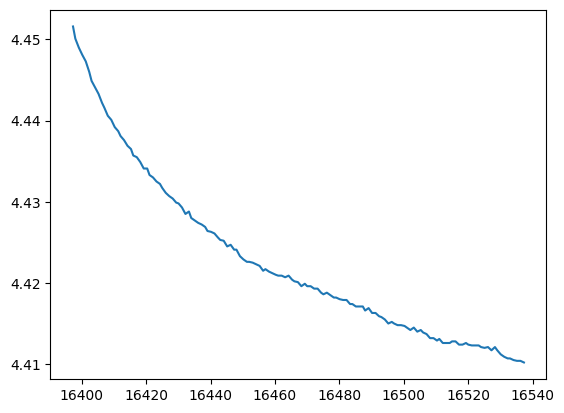

In [372]:
pot_split_new = []
t_split_new = []

#section 1 has 24 peaks
for i in range(1, 24):
    p_mx = np.max(pot_split[i])
    p_mn = np.min(pot_split[i])
    p_mx_ind = np.where((pot_split[i] == p_mx))
    p_mn_ind = np.where((pot_split[i] == p_mn))
    mx_ind = p_mx_ind[0][0]
    mn_ind = p_mn_ind[0][0]
    pot_split_n = np.zeros(mn_ind)
    t_split_n = np.zeros(mn_ind)
    pot_split_n[:mn_ind] = pot_split[i][mx_ind:mn_ind]
    t_split_n[:mn_ind] = t_split[i][mx_ind:mn_ind]
    indices_to_remove = [0, 1, 2,3, 4, 5, 6, 7, 8, 9, 10]
    pot_split_n =  pot_split_n[~np.isin(np.arange( pot_split_n.size), indices_to_remove)]
    t_split_n = t_split_n[~np.isin(np.arange(t_split_n.size), indices_to_remove)]
    pot_split_new.append(pot_split_n)
    t_split_new.append(t_split_n)


plt.plot(t_split_new[1], pot_split_new[1])



In [373]:
#functions 
def analyse_chunk(ch, t_split_new, pot_split_new):
    pot_chunk = pot_split_new[ch]
    t_chunk = t_split_new[ch]
    t_real_chunk = t_split_new[ch] - t_split_new[ch][0]
    totaltime = len(t_real_chunk)
    #totaltime = int(t_split_new[ch][-1]-t_split_new[ch][0])
    return totaltime, pot_chunk, t_real_chunk, t_chunk

In [374]:
def voltages_data(diff, totaltime):
    volt = np.array((totaltime), order="F")
    volt = f90_src.datafitpde.crank_nicholson(n=n, totaltime=totaltime, d=diff, r=R, volper=volPer,
                                              iapp=iapp, f=F, l=L, rg=Rg, t=T, k=K, maxcon=maxCon,
                                              c0=c0, dt=dt)
    #simulation time, dt = 1
    time_plot = np.zeros(totaltime)
    for i in range(totaltime):
        time_plot[i]=i 
        
    return volt, time_plot

#volt_simul, time_simul = voltages_data(D, totaltime)

In [375]:
def interpolate_point(volt_simul, time_simul, t):
        time = math.floor(t)
        v1 = volt_simul[time]
        t1 = time_simul[time]
        t2 = time_simul[time+1]
        v2 = volt_simul[time+1]
        time_array = [t1, t2]
        volt_array = [v1, v2]
        v_int = np.interp(t, time_array, volt_array)
        t_int = t
        return v_int, t_int
    

In [376]:
#make an array of interpolated points for the optimiser
def create_int_array(volt_simul, time_simul, t_chunk, pot_chunk):
    v_inter = np.zeros(len(t_real_chunk))
    t_inter = np.zeros(len(t_real_chunk))
    for i in range(len(t_real_chunk)-1):
        vi, ti = interpolate_point(volt_simul, time_simul, t_real_chunk[i])
        t_inter[i] = ti
        v_inter[i] = vi
    v_inter[-1] = v_inter[-1-1]
    t_inter[-1] = t_inter[-1-1]
    return t_inter, v_inter

In [377]:
#chunk of experimental data to analyse (min = 1, max = 24)
ch = 1
n = 20
D = 1.48 * 10**(-15)
R = 5.22 * 10**(-6)
volPer = 66.5
iapp = -48.65656
F = 96485.3321
L = 75.6 * 10**(-6)
Rg = 8.31446261815324
T = 294.15
K = 3.42
maxCon = 51765.0000001
c0 = np.ones(n, order="F")
c0 = c0*40000
c0 = np.asfortranarray(c0)
#timeArr = t_split[1] 
#timeArr = np.asfortranarray(timeArr)
#maxcon=np.array([maxCon], dtype=float)
dt = 1



In [378]:
totaltime, pot_chunk, t_real_chunk, t_chunk = analyse_chunk(ch, t_split_new, pot_split_new)
volt_simul, time_simul = voltages_data(D, totaltime)
t_int, v_int = create_int_array(volt_simul, time_simul, t_chunk, pot_chunk)
#introduce I*R shift
difference = np.average(volt_simul-pot_chunk)

 Flux b.c. rescaled: 
 Diffusion coefficient is:    1.4800000000000002E-015


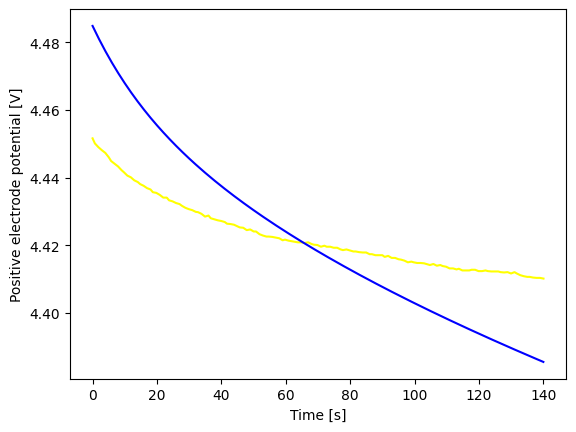

In [379]:
#plot experimental data vs interpolation from the simulation
plt.plot(t_real_chunk, pot_chunk, color="yellow")
plt.plot(time_simul, volt_simul-difference, color="blue")
#plt.plot(t_int, v_int, 'x')
plt.xlabel("Time [s]")
plt.ylabel("Positive electrode potential [V]")
plt.show()

In [380]:
D_guess = 1.48 * 10**(-15)
def error(D):
    volt, time  = voltages_data(D, totaltime)
    volt = volt-difference
    err = volt-pot_chunk
    sum_err = np.sum(err**2)
    return sum_err

In [381]:
optim = minimize(fun=error, x0=D_guess)

 Flux b.c. rescaled: 
 Diffusion coefficient is:    1.4800000000000002E-015
 Flux b.c. rescaled: 
 Diffusion coefficient is:    1.4901162673847655E-008
 Flux b.c. rescaled: 
 Diffusion coefficient is:   -1.0099999999999985     
 Flux b.c. rescaled: 
 Diffusion coefficient is:   -1.0099999850988373     
 Flux b.c. rescaled: 
 Diffusion coefficient is:  -0.34660690710875214     
 Flux b.c. rescaled: 
 Diffusion coefficient is:  -0.34660689220759094     
 Flux b.c. rescaled: 
 Diffusion coefficient is:  -0.10089579871762216     
 Flux b.c. rescaled: 
 Diffusion coefficient is:  -0.10089578381646097     
 Flux b.c. rescaled: 
 Diffusion coefficient is:   -3.4361917053029149E-002
 Flux b.c. rescaled: 
 Diffusion coefficient is:   -3.4361902151867955E-002
 Flux b.c. rescaled: 
 Diffusion coefficient is:   -1.1300386003619864E-002
 Flux b.c. rescaled: 
 Diffusion coefficient is:   -1.1300371102458670E-002
 Flux b.c. rescaled: 
 Diffusion coefficient is:   -3.7684989015783674E-003
 Flux b.c. r

In [382]:
D_new = optim.x[0]
volt_new, time_new  = voltages_data(D_new, totaltime)
volt_new = volt_new-difference

 Flux b.c. rescaled: 
 Diffusion coefficient is:    1.4800000000000002E-015


In [385]:
optim

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.03692886977811555
        x: [ 1.480e-15]
      nit: 0
      jac: [ 2.419e+07]
 hess_inv: [[1]]
     nfev: 52
     njev: 20

In [383]:
volt_new

array([4.48479222, 4.48281692, 4.48091471, 4.47908139, 4.47731302,
       4.47560592, 4.47395663, 4.47236193, 4.4708188 , 4.46932439,
       4.46787605, 4.46647129, 4.46510778, 4.46378331, 4.46249584,
       4.46124342, 4.46002424, 4.45883661, 4.45767891, 4.45654965,
       4.4554474 , 4.45437084, 4.45331871, 4.45228983, 4.4512831 ,
       4.45029746, 4.44933194, 4.44838559, 4.44745756, 4.446547  ,
       4.44565315, 4.44477527, 4.44391266, 4.44306466, 4.44223066,
       4.44141008, 4.44060234, 4.43980694, 4.43902338, 4.43825118,
       4.4374899 , 4.43673912, 4.43599844, 4.43526747, 4.43454587,
       4.43383328, 4.43312939, 4.43243388, 4.43174646, 4.43106686,
       4.4303948 , 4.42973003, 4.42907233, 4.42842144, 4.42777717,
       4.42713929, 4.42650761, 4.42588195, 4.42526211, 4.42464794,
       4.42403925, 4.4234359 , 4.42283773, 4.42224459, 4.42165636,
       4.42107289, 4.42049407, 4.41991976, 4.41934984, 4.41878422,
       4.41822278, 4.41766541, 4.41711202, 4.41656251, 4.41601

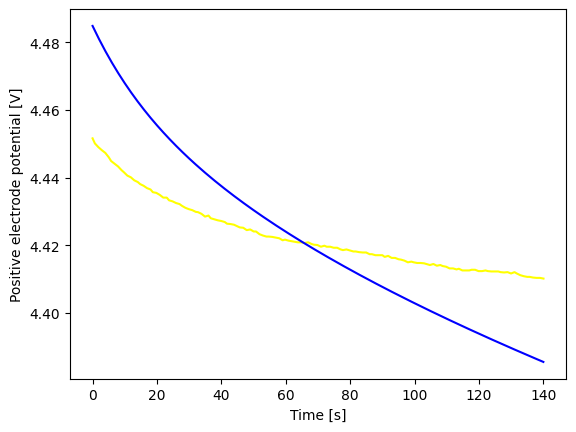

In [384]:
#plot experimental data vs interpolation from the simulation
plt.plot(t_real_chunk, pot_chunk, color="yellow")
plt.plot(time_new, volt_new, color="blue")
#plt.plot(t_int, v_int, 'x')
plt.xlabel("Time [s]")
plt.ylabel("Positive electrode potential [V]")
plt.show()